In [1]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [2]:
from openvqe.common_files.get_energy_WSSVQE import * # this file.py import all the defined function to here .ipynb

/home/nathan/miniconda/envs/openvqe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#model = ising(4) 
#print("Transverse Ising Model:", model)

In [4]:
name = Molecule_Generator("H2")

In [5]:
r, geometry, charge, spin, basis = name
(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_elec,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(
    geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
)
print("Number of electrons = ", n_elec)
nqbits = rdm1.shape[0] * 2
print("Number of qubits before active space selection = ", nqbits)
# print("rdm1", rdm1)
# print(info)
print("Orbital energies = ", orbital_energies)
print("Nuclear repulsion = ", nuclear_repulsion)

Number of electrons =  2
Number of qubits before active space selection =  4
Orbital energies =  [-0.4908283   0.47080536]
Nuclear repulsion =  0.5399767458367347


In [6]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.transforms import transform_to_jw_basis

mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
H = mol_h.get_electronic_hamiltonian()
hamiltonian_sp = transform_to_jw_basis(H)
print(hamiltonian_sp)

(-0.31538790473063794+0j) * I^4 +
(0.1574918558293463+0j) * (ZZ|[0, 1]) +
(0.10729348765520527+0j) * (ZZ|[0, 2]) +
(0.15617538348132448+0j) * (ZZ|[1, 2]) +
(0.15617538348132448+0j) * (ZZ|[0, 3]) +
(0.13943713589673473+0j) * (Z|[0]) +
(0.10729348765520527+0j) * (ZZ|[1, 3]) +
(0.13943713589673476+0j) * (Z|[1]) +
(0.048881895826119175+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.048881895826119175+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.048881895826119175+0j) * (YYXX|[0, 1, 2, 3]) +
(0.048881895826119175+0j) * (YXXY|[0, 1, 2, 3]) +
(0.16407160243062638+0j) * (ZZ|[2, 3]) +
(-0.13600541087956453+0j) * (Z|[2]) +
(-0.13600541087956453+0j) * (Z|[3])


In [7]:
#Define the model 
model = hamiltonian_sp

#### Step 2: Define the ansazt model and display 

In [8]:
nqbits = 4
depth = 4


k_lst = [0, 1]
prog = Program()
init_theta_list = np.random.random(2 * nqbits * (depth + 1) + 2) * 1e-1  # Imported as it is on the SSVQE qulacs
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(init_theta_list))]




def create_circuit(k):
    return circuit_ansatz(4, k, 4, theta)

# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()


weight = [2,1]


This applied state is  0000
This applied state is  0001


In [9]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from numpy import binary_repr
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"
model = hamiltonian_sp
vals = 15

eigenvec_input_tar = calculate_eigen_vectors(model, vals)
eigenvec_input = [eigenvec_input_tar[2],eigenvec_input_tar[8]] 


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}
fidelity_lists = {f"fidelity_circ_{i}": {method: []} for i in range(len(circuits_store))}


input_funct, callback = opt_funct(circuits_store, model, qpu, nqbits, energy_lists, fidelity_lists, weight, eigenvec_input)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=init_theta_list, method=method, callback=callback, options=options)



/home/nathan/miniconda/envs/openvqe/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


[-0.34365999 -0.73471515 -1.10531794  0.06379356  0.53997675 -0.04309338
 -0.04309338 -0.58081898 -0.73471515 -0.03679734 -0.58081898 -0.73471515
 -0.03679734 -0.60084192 -0.60084192  0.52624985]
         Current function value: -2.945351
         Iterations: 90
         Function evaluations: 4386
         Gradient evaluations: 102


In [10]:
#Storing information

iterations = {
    "minimum_energy_result": [],
    "theta_optimized_result": [],
    "optimized_result_ground": [],
    "optimized_result_exci": [],

}

xlist = Optimizer.fun
ylist = Optimizer.x


opt_circ_ground = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})
zlist_ground = {k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)} 

opt_circ_exci = circuits_store[1].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})
zlist_exci = {k: v for k, v in zip(sorted(circuits_store[1].get_variables()), Optimizer.x)} 




iterations["minimum_energy_result"].append(xlist) 
iterations["theta_optimized_result"].append(ylist)
iterations["optimized_result_ground"].append(zlist_ground ) 
iterations["optimized_result_exci"].append(zlist_exci)

print(iterations)

{'minimum_energy_result': [-2.9453510273151813], 'theta_optimized_result': [array([ 1.75109453e+00,  1.60584214e-05,  3.72742996e-05,  1.26790673e-08,
        5.36229796e-02, -3.41067038e-01, -2.65910697e-02,  1.57079483e+00,
       -3.82350704e-05, -8.22714860e-07, -3.64630229e-06, -7.14309226e-02,
        2.43214109e-07,  6.62729996e-02, -5.97611243e-07, -3.08846065e-02,
        1.57566718e+00,  1.07130450e-04,  3.14158750e+00, -6.16713309e-07,
       -2.53349797e-07,  1.04734359e-01, -1.57079026e+00, -1.62860002e-03,
        4.11969301e-02,  1.88956672e+00, -6.72536759e-03, -1.57079021e+00,
        1.16829660e-01, -3.47276223e-08,  2.16534587e-02,  7.13762287e-07,
        3.84570805e-02,  2.92773899e-04,  1.71275445e+00,  3.39492931e-02,
       -3.90778932e-08,  6.09770890e-02, -1.39272382e-06,  8.26414063e-02,
        1.56621476e+00,  5.91238659e-02])], 'optimized_result_ground': [{'\\theta_{0}': 1.7510945341464488, '\\theta_{10}': 1.605842136514344e-05, '\\theta_{11}': 3.727429960

#### Plotting results

Final energy for k=0000: -1.1053179363364287
Final energy for k=0001: -0.7347151546423237


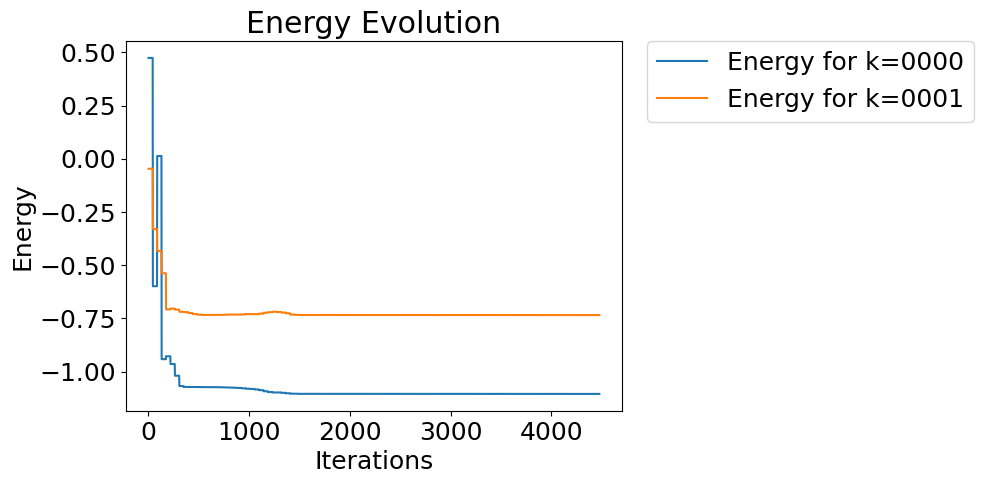

Final fidelity for k=0000: 0.9999999999534368
Final fidelity for k=0001: 0.9711997365076607


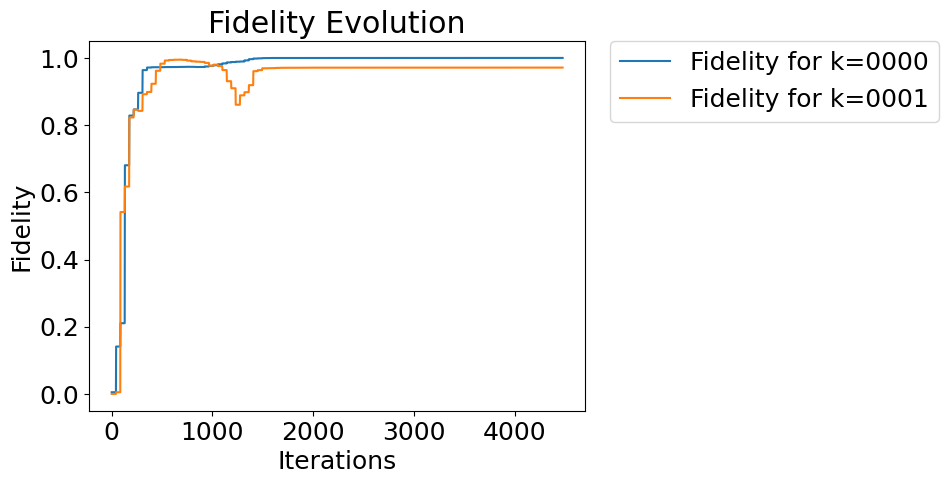

In [11]:
# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final energy for each k
    final_energy = energy_list[-1]
    print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

# Plot fidelity
plt.figure()
all_fidelity_lists = []
for i in range(len(circuits_store)):
    fidelity_list = fidelity_lists[f"fidelity_circ_{i}"][method]
    all_fidelity_lists.append(fidelity_list)
    plt.plot(range(len(fidelity_list)), fidelity_list, label=f"Fidelity for k={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final fidelity for each k
    final_fidelity = fidelity_list[-1]
    print(f"Final fidelity for k={binary_repr(k_lst[i]).zfill(4)}: {final_fidelity}")


plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()